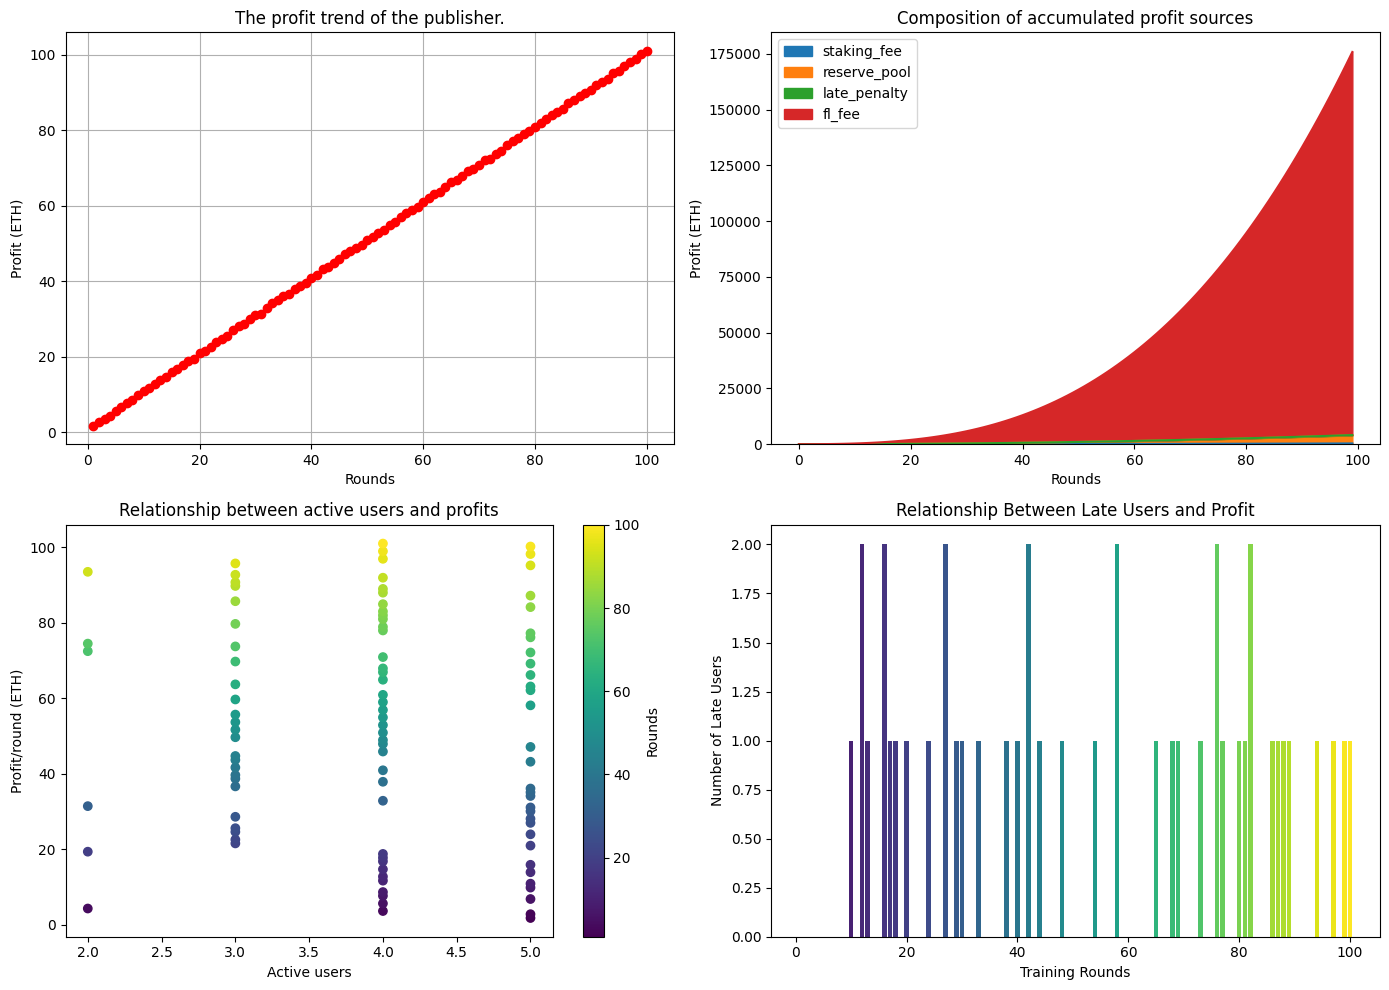

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class FLUser:
    def __init__(self, address):
        self.address = address
        self.reputation = 500  # 初始声誉（0-1000）
        self.stake_history = []
        self.reward_history = []
        self.penalty_history = []
        self.participation_rate = np.random.uniform(0.7, 1.0)

class FLPublisher:
    def __init__(self):
        self.profit_sources = {
            'staking_fee': 0.0,    # 质押手续费（2%）
            'reserve_pool': 0.0,   # 储备金池（20%）
            'late_penalty': 0.0,   # 迟到惩罚（5%）
            'fl_fee': 0.0          # FL服务费（1 ETH/轮）
        }
        self.total_profit = 0.0
        self.profit_history = []
        
    def calculate_profit(self, total_stakes, late_users=0, fl_round=0):
        # 质押手续费（2%）
        fee = total_stakes * 0.02
        self.profit_sources['staking_fee'] += fee
        
        # 迟到惩罚（5%）
        penalty = late_users * 0.05 * 1  # 假设基础质押1 ETH
        self.profit_sources['late_penalty'] += penalty
        
        # FL服务费
        service_fee = 1.0 * (fl_round + 1)  # 每轮递增1 ETH
        self.profit_sources['fl_fee'] += service_fee
        
        # 储备金池（动态计算）
        reserve = total_stakes * 0.2
        self.profit_sources['reserve_pool'] += reserve
        
        # 累计总利润
        round_profit = fee + penalty + service_fee + reserve
        self.total_profit += round_profit
        self.profit_history.append({
            'round': fl_round + 1,
            'total': round_profit,
            'breakdown': self.profit_sources.copy()
        })

class FLSimulator:
    def __init__(self, num_users=10, rounds=10):
        self.users = [FLUser(f"User{i+1}") for i in range(num_users)]
        self.publisher = FLPublisher()
        self.base_stake = 1.0  # 基础质押（ETH）
        self.rounds = rounds
        self.results = []
        
    def run_simulation(self):
        for round in range(self.rounds):
            round_data = self._simulate_round(round)
            self.results.append(round_data)
        return pd.DataFrame(self.results)
    
    def _simulate_round(self, round):
        # 阶段1：质押参与
        total_stakes = 0
        late_users = 0
        
        for user in self.users:
            if np.random.random() < user.participation_rate:
                # 动态质押计算
                effective_stake = self.base_stake * (1 - user.reputation/2000)
                
                # 最后1小时加入的视为迟到
                if np.random.random() < 0.1:  # 假设10%迟到率
                    late_users += 1
                    effective_stake *= 0.95  # 5%惩罚
                    
                user.stake_history.append(effective_stake)
                total_stakes += effective_stake
            else:
                user.stake_history.append(0)
        
        # 计算发布方收益
        self.publisher.calculate_profit(total_stakes, late_users, round)
        
        # 阶段2：模型训练与奖励分配
        active_users = [u for u in self.users if u.stake_history[-1] > 0]
        total_rewards = total_stakes * 1.2  # 20%收益
        
        for user in active_users:
            # 模型质量与声誉相关
            quality = np.random.beta(user.reputation/500 + 1e-6, 2)
            reward = quality * total_rewards / len(active_users)
            
            # 声誉更新规则
            rep_change = int(50 * (quality - 0.6))  # 质量>0.6增加声誉
            user.reputation = np.clip(user.reputation + rep_change, 0, 1000)
            
            user.reward_history.append(reward)
            user.penalty_history.append(0 if quality >=0.6 else 0.05)
        
        # 收集回合数据
        return {
            'round': round+1,
            'total_stakes': total_stakes,
            'active_users': len(active_users),
            'avg_reputation': np.mean([u.reputation for u in self.users]),
            'publisher_profit': self.publisher.profit_history[-1]['total'],
            'late_users': late_users
        }

# 初始化并运行模拟
R = 100
U = 5
simulator = FLSimulator(num_users=U, rounds=R)
results_df = simulator.run_simulation()

# 利润构成分析
profit_breakdown = pd.DataFrame(
    [x['breakdown'] for x in simulator.publisher.profit_history]
)
profit_breakdown['round'] = range(1, R+1)

# 可视化
plt.figure(figsize=(14, 10))

# 利润趋势分析
plt.subplot(2, 2, 1)
plt.plot(results_df['round'], results_df['publisher_profit'], 'r-o')
# plt.title('发布方利润增长趋势')
plt.title('The profit trend of the publisher.')
plt.xlabel('Rounds')
plt.ylabel('Profit (ETH)')
plt.grid(True)

# 利润来源构成
plt.subplot(2, 2, 2)
profit_breakdown.drop(columns='round').cumsum().plot.area(ax=plt.gca())
# plt.title('累计利润来源构成')
plt.title('Composition of accumulated profit sources')
plt.xlabel('Rounds')
plt.ylabel('Profit (ETH)')

# 利润与活跃用户关系
plt.subplot(2, 2, 3)
plt.scatter(results_df['active_users'], results_df['publisher_profit'], 
           c=results_df['round'], cmap='viridis')
plt.colorbar(label='Rounds')
# plt.title('活跃用户与利润关系')
plt.title('Relationship between active users and profits')
# plt.xlabel('活跃用户数')
# plt.ylabel('单轮利润 (ETH)')
plt.xlabel('Active users')
plt.ylabel('Profit/round (ETH)')


# 迟到用户影响
plt.subplot(2, 2, 4)
norm = plt.Normalize(vmin=results_df['publisher_profit'].min(), vmax=results_df['publisher_profit'].max())
colors = plt.cm.viridis(norm(results_df['publisher_profit']))
plt.bar(results_df['round'], results_df['late_users'], color=colors)
# plt.title('迟到用户与利润关系')
# plt.xlabel('训练轮次')
# plt.ylabel('迟到用户数')
plt.title('Relationship Between Late Users and Profit')
plt.xlabel('Training Rounds')
plt.ylabel('Number of Late Users')



plt.tight_layout()
plt.show()

### 参数敏感性测试

Text(0, 0.5, 'Total Profit (ETH)')

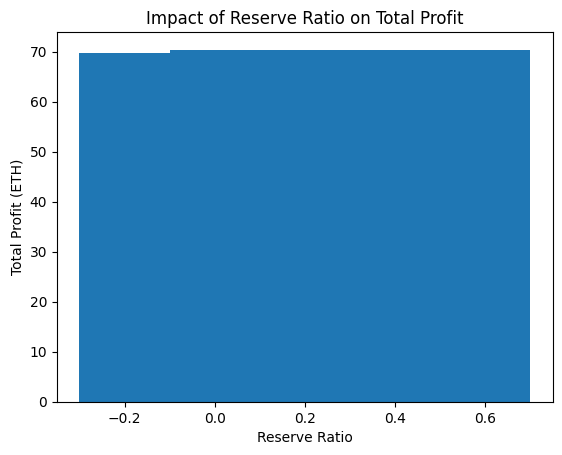

In [15]:
# 测试储备金比率的影响
reserve_rates = [0.1, 0.2, 0.3]
total_profits = []
for rate in reserve_rates:
    sim = FLSimulator()
    sim.publisher.reserve_rate = rate
    sim.run_simulation()
    total_profits.append(sim.publisher.total_profit)

plt.bar(reserve_rates, total_profits)
# plt.title('储备金比率对总利润的影响')
# plt.xlabel('储备金比率')
# plt.ylabel('总利润 (ETH)')

plt.title('Impact of Reserve Ratio on Total Profit')
plt.xlabel('Reserve Ratio')
plt.ylabel('Total Profit (ETH)')
